In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy
import networkx as nx


import torch                                                # !pip install -q torch


# Generating a problem instance 

Here, the task is to find the minimum energy (ground) state of the Hamiltonian
$H=\sum_{i>j} w_{ij}\sigma_i\sigma_j$, where $\sigma$ is the Pauli z-operator,
$i,j\in\{1,\cdots,n\}$, $n$ is the number of qubits, a real number $w_{ij}$ represent zz-interaction strenngth between $i$th and $j$th qubit.
One can represent the whole situation through a graph like given below.

This task is equivalent to a Quadratic Unconstrained Binary Optimization (QUBO) problem, which belongs to the NP-hard class of problems such as Max-Cut, Vertex Cover, etc.

For more details see: Lucas A (2014) Ising formulations of many NP problems. Front. Physics 2:5. doi: 10.3389/fphy.2014.00005 https://doi.org/10.3389/fphy.2014.00005



[[0 2 1 2 3 1 3 1 2 2 2 2]
 [0 0 0 3 3 0 0 0 0 3 1 3]
 [0 0 0 3 2 3 3 3 3 3 2 0]
 [0 0 0 0 0 1 0 2 1 2 1 0]
 [0 0 0 0 0 2 0 2 0 2 1 0]
 [0 0 0 0 0 0 2 2 0 3 2 2]
 [0 0 0 0 0 0 0 3 2 2 1 2]
 [0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]] = weight (adjacency) matrix


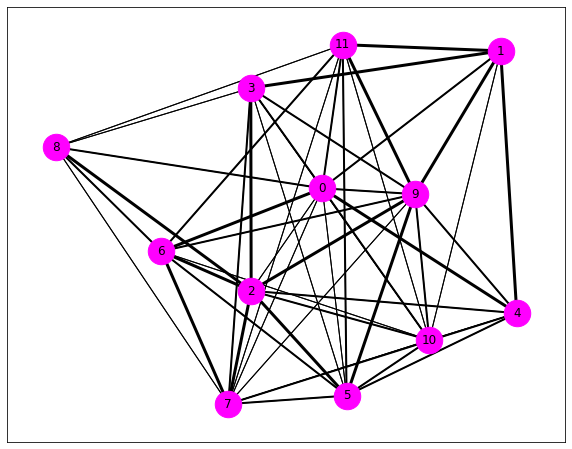

In [2]:
n = 12                                 # = number of qubits
num_pairs = int((n**2 - n)/2)          # number of qubit-pairs
dim = 2**n                             # dimension of the n-qubit Hilbert space

W = np.random.randint(0,4,(n, n))      # weight (interaction strength) between ith and jth qubits, where i<j
W = np.triu(W, 1)

print(f'{W} = weight (adjacency) matrix')

#---------------------------------------------------------------------------- 
'''In the graph, a node represents a qubit,
the width of an edge represents the interaction strength W_ij between a pair (i,j) of qubits.'''

plt.subplots(figsize=(10,8))  
g = nx.Graph()
for i in range(n):
    for j in range(i+1, n):
        if W[i,j]!=0: 
            g.add_edge(str(i), str(j), weight=W[i,j])

pos = nx.spring_layout(g, seed=0)
nx.draw_networkx(g, pos, node_size= 700, node_color='magenta')

for edge in g.edges(data='weight'):
    nx.draw_networkx_edges(g, pos, edgelist=[edge], width=edge[2]) #draw edges with corresponding thicknesses W_ij

#----------------------------------------------------------------------------

#g.edges(data='weight')



# finding minimum energy with an exhaustive search

When n is large, say, 50 then the number of different energies $E_z=\langle z|H|z\rangle$ will be $2^{50}$ (an exponentially large number). As a result, it is impossible to store all of them in a computer and it is NP-hard to find a minimum energy (ground) state using the function 

energy(z, W) $= E_z = \langle z|H|z\rangle= z_{spin} W z_{spin}$

defined below. So, here with a variational quantum algorithm, we are trying to find z for which $E_z$ is as small as possible ($z=0,\cdots,2^n$).



for more details: 
Peruzzo, A., McClean, J., Shadbolt, P. et al. A variational eigenvalue solver on a photonic quantum processor. Nat Commun 5, 4213 (2014). https://doi.org/10.1038/ncomms5213

energies for different z = [...E_z...] = [102  72  74 ...  74  72 102]


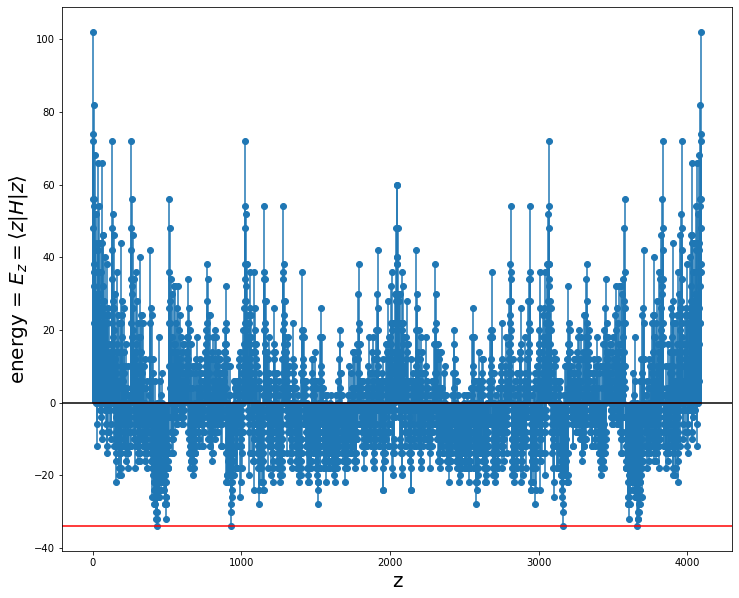

global min_energy = -34
global min_energy z eigenstates = [ 431  931 3164 3664]

global max_energy = 102


In [3]:
def energy(z, W):                                              # z in an integer, one-to-one correspondence: z <--> z_bin <---> z_spin
    z_bin = np.array([int(x) for x in np.binary_repr(z, n)])   # z_bin has n components, each one is either   0 (spin-up) or  1(spin-down)
    z_spin = 1-2*z_bin                                         # z_spin has n components, each one is either +1 (spin-up) or -1(spin-down)
    E = np.linalg.multi_dot([z_spin, W, z_spin])               # E_z = energy for a given z
    return E
    

def energies(W):
    n = W.shape[0]                  # number of qubits
    dim = 2**n                      # dimension of the n-qubit Hilbert space
    zE = []
    for z in range(dim):                                                                                
        E = energy(z, W)              
        zE.append([z, E])
    return np.array(zE)             # collection of all possible 2**n energies for different z

#----------------------------------------------------------------------------  
        
zE = energies(W=W)
eng = zE[:,1] 
print(f'energies for different z = [...E_z...] = {eng}')

H = np.diag(eng)                   # Hamiltonian is diagonal in the z-basis, and its diagonal is made of eng = {E_z}

#==============================================================================

min_eng = np.min(eng)
max_eng = np.max(eng)

plt.rcParams["figure.figsize"] = (12,10)
plt.stem(eng, basefmt=None)
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = min_eng, color = 'red', linestyle = '-')
plt.ylabel(r'energy = $E_z = \langle z|H|z\rangle$', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.show()

print(f'global min_energy = {min_eng}')
print(f'global min_energy z eigenstates = {np.where(eng==min_eng)[0]}\n')
print(f'global max_energy = {max_eng}')
    
#--------------------------------------------------------------------------------------
eng = torch.tensor(eng, dtype=torch.float64) 

$ $


# Training a Quantum Neural Network (QNN) using PyTorch


## QNN = parameterized quantum circuit (PQC)


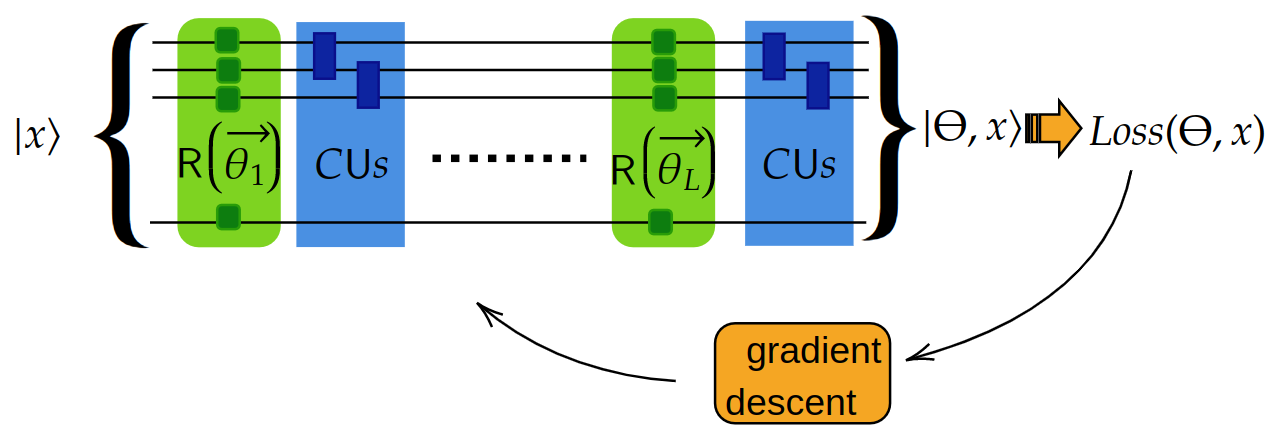

A PQC is made of $L$ quantum layers. 
Here, each quantum layer has two parts: rotation $\text{R}(\vec{\theta})$ in green and entangling $\text{CUs}$ in blue.

$ $

$\bullet$ The rotation part is made of the tensor-product 
$\ \text{R}(\vec{\theta}) = \displaystyle\bigotimes_{i} \text{R}(\theta_i)\ $
of single-qubit rotations (unitary gates)
$\ \text{R}(\theta) = \cos(\theta) I + \texttt{i}\sin(\theta)\,\sigma\ $
where $i\in\{1,\cdots,n\}$ is the qubit-index, the angles $\vec{\theta}=(\theta_1,\cdots,\theta_n)$ of rotations are learnable parameters, and $n$ is the number of qubits. <br>

$ $


$\bullet$ The entangling part is made of the tensor-product 
$\text{CUs} = \displaystyle\bigotimes_{(i,j)} \text{CU}_{(i,j)}$
of two-qubit controlled-Pauli_operators
$\text{CU}_{(i,j)} = |0\rangle_i\langle 0|\otimes I +|1\rangle_i\langle 1|\otimes\sigma_j$,
where $(i,j)$ represents the pair of control and target qubits $i$ and $j$, respectively.
This part will create entanglement between qubits and facilitate quantum information transfer between qubits. 
However, this part carries no learnable parameters

$ $

$\bullet$ Input to the PQC is a $l_2$-normalized (quantum state) vector $|x\rangle$ of $\text{dim}=2^n$ components, that can be learnable parameters.
After the PQC, we perform measurement on $|x,\Theta\rangle$ in the $z$-basis (computational-basis) and get a probability-vector $\textbf{p}(x,\Theta)=(p_0,\cdots,p_{\text{dim}})$.
With $\textbf{p}(x,\Theta)$ we compute 
$Loss(x,\Theta)=\langle x,\Theta|H|x,\Theta\rangle=\sum_{z=0}^{\text{dim}}p_z E_z$
that is an energy expectation value, which we want to minimize to find the ground state of the Hamiltonian $H$.
$\Theta=\{\vec{\theta}_1, \cdots, \vec{\theta}_L\}$.


$ $

For details on the parameterized quantum circuit, see https://iopscience.iop.org/article/10.1088/2058-9565/ab4eb5
 


## The entangling part CUs 

In [4]:
"Pauli operators = sigma's" 

I2 = np.identity(2)    # single qubit Identity Matrix (gate). Qubit is a 2-level quantum system.

sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

P0 = np.array([[1,0],[0,0]])   # projector |0><0| 
P1 = np.array([[0,0],[0,1]])   # projector |1><1|

#=====================================================================================

"Control_Us = Control_sigma between each qubit-pair"


def operator0(v):         # v in {0,1,2} will select different items in the sum
    op0 = I2*(1-v)*(2-v)/2 + P0*v*(2-v) + I2*v*(v-1)/2
    return op0

def operator1(v, sigma):   # v in {0,1,2}
    op1 = I2*(1-v)*(2-v)/2 + P1*v*(2-v) + sigma*v*(v-1)/2
    return op1


for v in range(3): print(f'for v={v}:', [(1-v)*(2-v)/2 , v*(2-v) ,v*(v-1)/2])


#--------------------------------------------------------------------------------------

def Control_Us(n_qubit, sigma):
    CUs = np.identity(np.power(2, n_qubit))     
    for i in range(n_qubit):                    # for each qubit pair (i,j) 
        for j in range(i+1, n_qubit):
            one_zero_n = np.zeros(n_qubit)
            one_zero_n[i]=1   # control qubit i set to 1
            one_zero_n[j]=2   # target  qubit j set to 2 and the rest are 0
            
            CU0 = operator0(one_zero_n[0])
            CU1 = operator1(one_zero_n[0], sigma)
            for k in range(n_qubit-1):
                CU0 = np.kron(CU0, operator0(one_zero_n[k+1]))
                CU1 = np.kron(CU1, operator1(one_zero_n[k+1], sigma))
            CU = CU0 + CU1
            #print(CU)
            CUs = CUs @ CU
    return CUs                                  # = tensor-product of two-qubit controlled_Unitaries


#--------------------------------------------------------------------------------------

CUs = Control_Us(n, sigma_x)
CUs = torch.tensor(CUs, dtype=torch.float64)             # Creates a Tensor from a numpy.ndarray.
CUs

for v=0: [1.0, 0, 0.0]
for v=1: [0.0, 1, 0.0]
for v=2: [0.0, 0, 1.0]


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

## QNN model

In [5]:
L = 3             
n_angs = n*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print("number of angles (learnable parameters of quantum circuit) = ", n_angs)


number of qubits =  12
number of quantum layers =  3
number of angles (learnable parameters of quantum circuit) =  36


In [6]:
class QNN(torch.nn.Module):        
    def __init__(self, n, L, CUs):
        super().__init__()
        self.n = n                                          # = number of qubits
        self.L = L                                          # = number of quantum layers
        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -torch.pi, torch.pi)
        self.angles = torch.nn.Parameter(angles)            # it makes angles learnable parameters
        
        self.CUs = CUs                                      # entangling part is the same for every quantum layer and has no learnable parameters
        
        x = torch.rand(2**n, dtype=torch.float64)-0.5 
        x = x/torch.linalg.norm(x, ord=2)                   # l2 normalization
        self.x = torch.nn.Parameter(x)                      # making components of input state |x> as learnable parameters             

        
    " The rotation part = Rotations on each qubit "
    def Ry(self, angs):                                  
        cos, sin = torch.cos(angs[0]), torch.sin(angs[0])
        rotation = torch.tensor([[cos, -sin],[sin, cos]])           
        for i in range(1, len(angs)):                      # one angles for each qubit         
            cos, sin = torch.cos(angs[i]), torch.sin(angs[i])
            rotation = torch.kron(rotation, torch.tensor([[cos, -sin],[sin, cos]]) )
        return rotation                                    # = multi-qubit rotation = tensor-product of single-qubit rotations around y-axis


    def forward(self): 
        for l in range(L):
            rotation = self.Ry(self.angles[l])
            x = torch.matmul(rotation, self.x)                # rotation part of lth quantum layer
            # print(torch.round(torch.matmul(rotation, rotation.T), decimals=10))         # Checking whether rotation is unitary or not.
            x = torch.matmul(self.CUs, x)                     # entangling part of lth quantum layer
            
        'after passing through the complete parameterized quantum circuits'
        x = x**2                     # = probabilities (After z-measurements on the output of parameterized quantum circuit)
        #print(torch.sum(x))         # Checking whether x is normalized or not (that is, probabilities add up to 1 or not)
        
        return x/torch.sum(x)        # making x normalized (that is, probabilities add up to 1 or not)


In [7]:
%%time

model = QNN(n, L, CUs)                                                        # Define model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-8)  # Define optimizer


def training():
    model.train()
    optimizer.zero_grad()               # Clear gradients
    out = model()                       # Perform a single forward pass, out = 𝐩(𝑥,Θ) = (𝑝0,⋯,𝑝dim) 
    #print(torch.sum(out))              # Checking whether probabilities add up to 1 or not
    loss = torch.dot(out, eng)          # 𝐿𝑜𝑠𝑠(𝑥,Θ)=⟨𝑥,Θ|𝐻|𝑥,Θ⟩ = ∑𝑝𝑧𝐸𝑧 is an energy expectation value
    loss.backward()                     # Derive gradients
    optimizer.step()                    # Update parameters based on gradients
    return loss


LOSS = []
for epoch in range(0, 101):
    loss = training()
    LOSS.append(loss.detach())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}   Loss: {loss:.4f}')

LOSS = np.array(LOSS)
print()

Epoch: 000   Loss: 0.0386
Epoch: 010   Loss: -17.9981
Epoch: 020   Loss: -21.6580
Epoch: 030   Loss: -24.1780
Epoch: 040   Loss: -26.1074
Epoch: 050   Loss: -27.6295
Epoch: 060   Loss: -28.8685
Epoch: 070   Loss: -29.9012
Epoch: 080   Loss: -30.7648
Epoch: 090   Loss: -31.4779
Epoch: 100   Loss: -32.0497

CPU times: user 1min 11s, sys: 18.2 s, total: 1min 29s
Wall time: 22.6 s


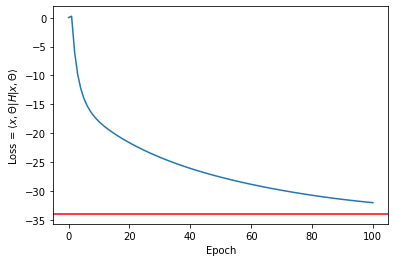

In [8]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(LOSS)
plt.axhline(y = min_eng, color = 'red', linestyle = '-') # = ground state energy
plt.ylabel(r'Loss = $\langle x,\Theta|H|x,\Theta\rangle$')
plt.xlabel('Epoch')
plt.show()

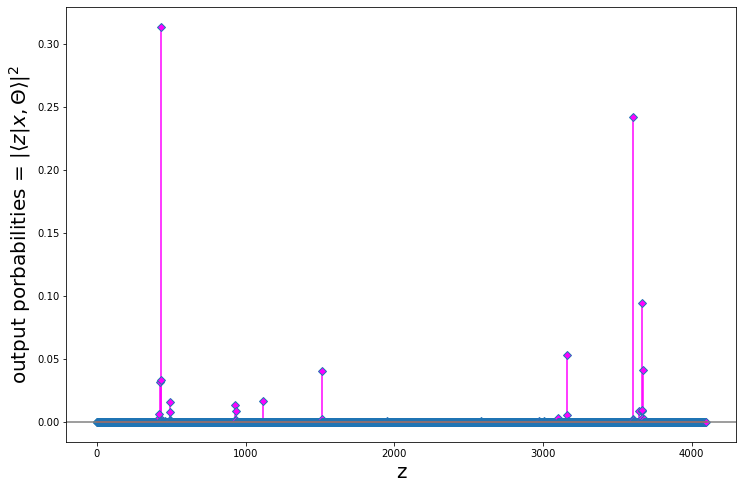

maximum probability = 0.314
z_solution corresponding to the maximum probability = 431

global min_energy z eigenstates = [ 431  931 3164 3664]

energy corresponding to z_solution = -34     [green dotted line in the bottom figure]
global min_energy = -34                      [red  line in the bottom figure]


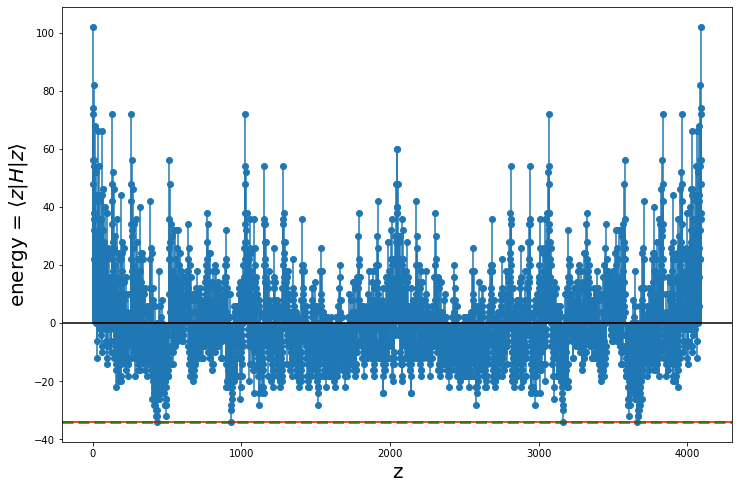

In [9]:
out_prob = model()             #After training output porbabilities
out_prob = out_prob.detach().numpy()

'''After the training, z corresponding to the maximum probability will be our solution'''

max_out_prob = np.max(out_prob)
z_max_out_prob = np.where(out_prob==max_out_prob)[0][0] 
eng_z_max_out_prob = energy(z_max_out_prob, W)



#============================================================================

plt.rcParams["figure.figsize"] = (12,8)
markerline, stemlines, baseline = plt.stem(np.arange(dim), out_prob, linefmt='magenta', markerfmt='D', bottom=0)
plt.setp(markerline, 'markerfacecolor', 'magenta')
plt.axhline(y = 0, color = 'gray', linestyle = '-')
plt.ylabel(r'output porbabilities = $|\langle z|x,\Theta\rangle|^2$', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.show()

#---------------------------------------------------------------------------
print(f'maximum probability = {round(max_out_prob,3)}')
print(f'z_solution corresponding to the maximum probability = {z_max_out_prob}\n')
print(f'global min_energy z eigenstates = {np.where(eng==min_eng)[0]}\n')
print(f'energy corresponding to z_solution = {eng_z_max_out_prob}     [green dotted line in the bottom figure]')
print(f'global min_energy = {min_eng}                      [red  line in the bottom figure]')

#---------------------------------------------------------------------------


plt.stem(eng)
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = min_eng, color = 'red', linestyle = '-')
plt.ylabel(r'energy = $\langle z|H|z\rangle$', fontsize=20)
plt.axhline(y = eng_z_max_out_prob, color = 'green', linestyle = '--', linewidth=3, alpha=0.7)
plt.xlabel('z', fontsize=20)
plt.show()
